In [17]:
import numpy as np
import math 
import random
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import t
from statsmodels.graphics.tsaplots import plot_acf
import scipy.stats as stats
from scipy.special import gamma
from scipy.stats.kde import gaussian_kde

#### Here we implement the first extension of the paper "Improving density forecasts"

#### As example we use our first application case with a student GARCH generated 

4000 4000


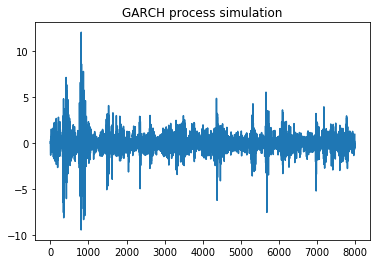

In [3]:
def simulated_GARCH(n,w=0.01,alpha=0.13,beta=0.86):
    h = [1]
    y = [0]
    for i in range(1,n):
        h.append(w + alpha * pow(y[i-1],2)  + beta * h[i-1])
        y.append(math.sqrt( h[i] * 4 / 6 ) * t.rvs(6))
    return y

y = simulated_GARCH(n=8000)
plt.plot(y)
plt.title("GARCH process simulation")
y_in_sample = y[:4000]
y_out_sample = y[4000:]
print(len(y_in_sample),len(y_out_sample))

In [4]:
def garch_filter(w,alpha,beta,data):
    n = len(data)
    sigma2 = np.zeros(n)
    sigma2[0] =1 #set initalize variance equal to unconditional variance
    for i in range(n):
        sigma2[i] = w + alpha * pow(data[i-1],2) + beta*sigma2[i-1]
    return sigma2

In [5]:
w = 0.01
alpha = 0.13
beta = 0.86
sigma2 = garch_filter(w,alpha,beta,y_out_sample)
z=[]
for i in range(len(y_out_sample)):
    z.append(stats.norm.cdf(y_out_sample[i],loc=0, scale=pow(sigma2[i],1/2)))

<Figure size 432x288 with 0 Axes>

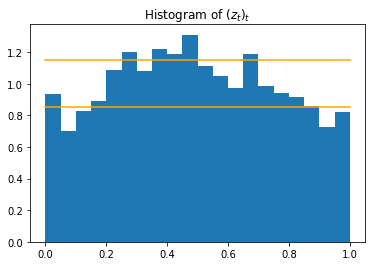

<Figure size 432x288 with 0 Axes>

In [6]:
plt.hist(z,bins=20,density=True)
plt.plot([0,1],[1.15,1.15] , color = 'orange')
plt.plot([0,1],[0.85,0.85] , color = 'orange')
plt.title("Histogram of $(z_t)_t$")
plt.figure()

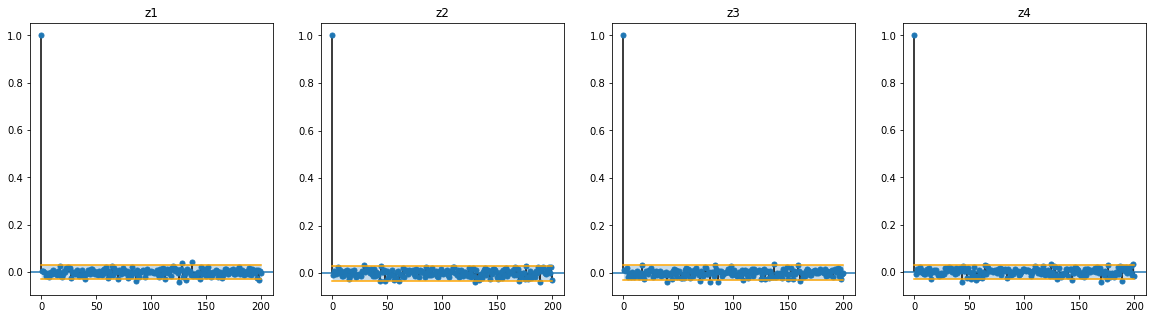

In [7]:
z_mean = sum(z)/len(z)
z1 = z-z_mean
z2 = pow(z-z_mean,2)
z3 = pow(z-z_mean,3)
z4 = pow(z-z_mean,4)
fig,ax = plt.subplots(1, 4,figsize=(20,5))
plot_acf(z1,lags=200,ax=ax[0],title='z1')
ax[0].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[0].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
plot_acf(z2,lags=200,ax=ax[1],title='z2')
ax[1].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[1].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
plot_acf(z3,lags=200,ax=ax[2],title='z3')
ax[2].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[2].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
plot_acf(z4,lags=200,ax=ax[3],title='z4')
ax[3].plot([0,200],[1.96/np.sqrt(4000),1.96/np.sqrt(4000)],color='orange')
ax[3].plot([0,200],[-1.96/np.sqrt(4000),-1.96/np.sqrt(4000)],color='orange')
plt.show()

If we want to compare the true density $f$ and the forecast $p$, under the assumption that $p$ is Gaussian we can say that $f \sim \mathcal{T}(6,\frac{\sigma_t^2 * 6}{4})$ and $p \sim \mathcal{N}(0,\sigma^2_t)$

In [8]:
p = []
f = []
sigma2 = garch_filter(w,alpha,beta,y_out_sample)
nu = 6
for i in range(len(y_out_sample)):
    f.append(stats.t.pdf(y_out_sample[i],loc = 0 , scale = math.sqrt(nu*sigma2[i]/(nu-2)),df=nu))
    p.append(stats.norm.pdf(y_out_sample[i],loc=0,scale= math.sqrt(sigma2[i])))

#### We plot the value of f versus the value of p

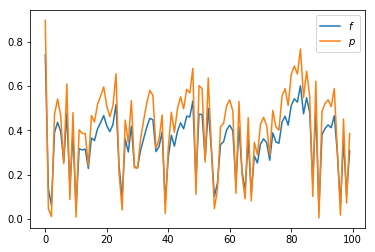

In [9]:
plt.plot(f[:100],label="$f$")
plt.plot(p[:100],label= "$p$")
plt.legend(loc="upper right")
plt.show()

We evaluate the empiric density $q$ of the random variable $z$. We use kernel estimation method, and scale parameters of $0.02$ to capture the butterfly effect

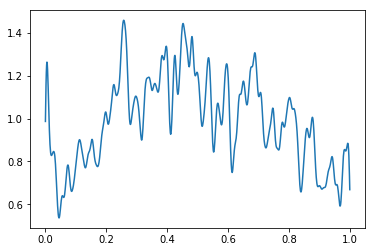

In [10]:
kde = gaussian_kde(z,bw_method=0.02)
x = np.linspace(0,1,1000)
y = kde.evaluate(x)
plt.plot(x,y)
plt.show()

In [11]:
pq = []
for i in range(len(y_out_sample)):
    pq.append(stats.norm.pdf(y_out_sample[i],loc=0,scale= math.sqrt(sigma2[i])*kde.pdf(z[i])[0]))

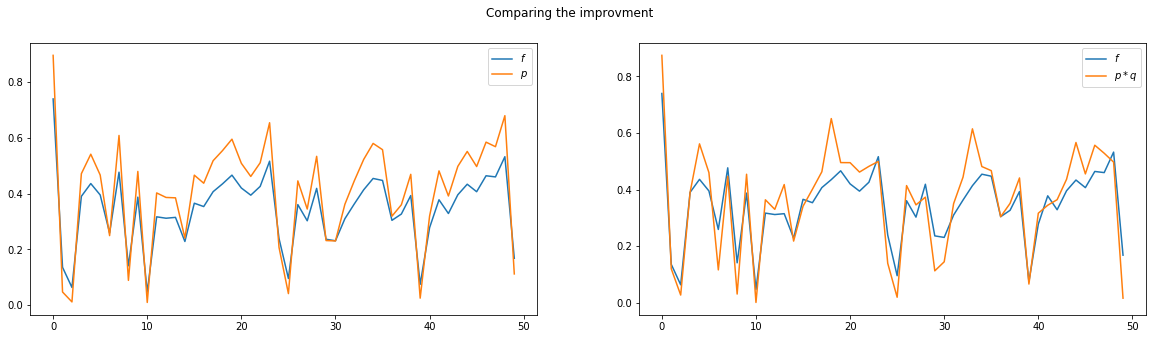

In [12]:
size = 50
_ , ax = plt.subplots(1, 2 , figsize=(20,5))
plt.suptitle("Comparing the improvment")
ax[0].plot(f[:size],label = "$f$")
ax[0].plot(p[:size],label = "$p$")
ax[0].legend(loc="upper right")
ax[1].plot(f[:size],label = "$f$")
ax[1].plot(pq[:size] , label ="$p *q$")
ax[1].legend(loc="upper right")
plt.show()

We can observe a really little upgrade, problem is we only have an estimator of $q$, so if we compte $ f = p \times q$ we can multiply 2 errors

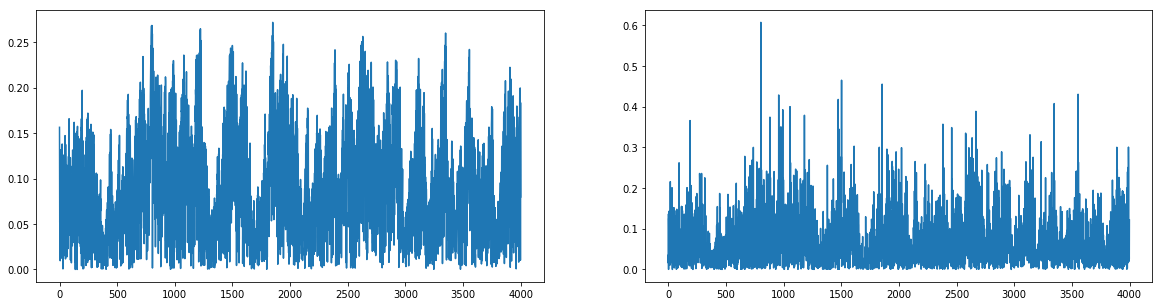

In [13]:
error1 = np.abs(np.asarray(f)-np.asarray(p))
error2 = np.abs(np.asarray(f)-np.asarray(pq))
_ , ax = plt.subplots(1, 2 , figsize=(20,5))
ax[0].plot(error1)
ax[1].plot(error2)
plt.show()

In [14]:
print(np.sum(error1))
print(np.sum(error2))

379.57203753729624
281.38881167021674


In [15]:
error1_cumsum = [error1[0]]
error2_cumsum = [error2[0]]
for i in range(1,4000):
    error1_cumsum.append(error1[i] + error1_cumsum[i-1])
    error2_cumsum.append(error2[i] + error2_cumsum[i-1])

#### Compute the cumulative sum of errors between $f$ and $p$ versus $f$ and $p*q$

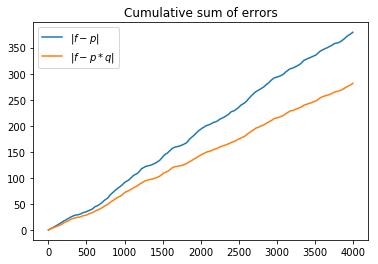

In [16]:
plt.figure()
plt.title("Cumulative sum of errors")
plt.plot(error1_cumsum,label = "$|f-p|$")
plt.plot(error2_cumsum , label = "$|f-p*q|$")
plt.legend(loc="upper left")
plt.show()

We obtain here a smaller sum of errors but it's not the cast on all simulation, if the length of data is not enough big. We can make a bad estimation of $q$ which lead to multiplying the error of $\hat{p}$ and $\hat{q}$ and gives a worst estimation